In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline


In [3]:
plt.style.use('seaborn')

# we will skip 2001 - 2005 due to bad quality

crimes1 = pd.read_csv('./input/Chicago_Crimes_2005_to_2007.csv',error_bad_lines=False)
crimes2 = pd.read_csv('./input/Chicago_Crimes_2008_to_2011.csv',error_bad_lines=False)
crimes3 = pd.read_csv('./input/Chicago_Crimes_2012_to_2017.csv',error_bad_lines=False)
crimes = pd.concat([crimes1, crimes2, crimes3], ignore_index=False, axis=0)

del crimes1
del crimes2
del crimes3

print('Dataset ready..')

print('Dataset Shape before drop_duplicate : ', crimes.shape)
crimes.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
print('Dataset Shape after drop_duplicate: ', crimes.shape)

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


Dataset ready..
Dataset Shape before drop_duplicate :  (6017767, 23)
Dataset Shape after drop_duplicate:  (4336556, 23)


In [4]:
crimes.drop(['Unnamed: 0', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On', 'FBI Code', 'Location'
            ], inplace=True, axis=1)

In [5]:
# convert dates to pandas datetime format
crimes.Date = pd.to_datetime(crimes.Date, format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
crimes.index = pd.DatetimeIndex(crimes.Date)

In [6]:
# of records X # of features
crimes['Y/M/D/H'] = crimes.Date.apply(lambda x: "%d/%d/%d/%d" % (x.year, x.month, x.day, x.hour))


In [7]:
#Let's have a look at the first 3 records and see if we see what we expect
crimes.head(3)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Y/M/D/H
Date,,,,,,,,,,,,,,,,
2006-04-02 13:00:00,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,1622,16.0,45.0,11.0,2006,41.981913,-87.771996,2006/4/2/13
2006-02-26 13:40:48,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,321,3.0,20.0,42.0,2006,41.775733,-87.611920,2006/2/26/13
2006-01-08 23:16:00,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,321,3.0,5.0,69.0,2006,41.769897,-87.593671,2006/1/8/23


In [8]:
crimes.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4336556 entries, 2006-04-02 13:00:00 to 2016-05-03 23:38:00
Data columns (total 16 columns):
ID                      int64
Date                    datetime64[ns]
Block                   object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
Year                    int64
Latitude                float64
Longitude               float64
Y/M/D/H                 object
dtypes: bool(2), datetime64[ns](1), float64(5), int64(3), object(5)
memory usage: 504.6+ MB


In [9]:
loc_to_change  = list(crimes['Location Description'].value_counts()[20:].index)
desc_to_change = list(crimes['Description'].value_counts()[20:].index)
#type_to_change = list(crimes['Primary Type'].value_counts()[20:].index)

crimes.loc[crimes['Location Description'].isin(loc_to_change) , crimes.columns=='Location Description'] = 'OTHER'
crimes.loc[crimes['Description'].isin(desc_to_change) , crimes.columns=='Description'] = 'OTHER'
#crimes.loc[crimes['Primary Type'].isin(type_to_change) , crimes.columns=='Primary Type'] = 'OTHER'

In [10]:
# we convert those 3 columns into 'Categorical' types -- works like 'factor' in R
crimes['Primary Type']         = pd.Categorical(crimes['Primary Type'])
crimes['Location Description'] = pd.Categorical(crimes['Location Description'])
crimes['Description']          = pd.Categorical(crimes['Description'])

In [11]:
# [Dempsy] - Currently changed the type of block/district/ward/community area to Categorical for Problem 1
block_to_change  = list(crimes['Block'].value_counts()[20:].index)
crimes.loc[crimes['Block'].isin(block_to_change), crimes.columns=='Block'] = 'OTHER'
crimes['Block']                = pd.Categorical(crimes['Block'])

crimes['District']             = pd.Categorical(crimes['District'])
crimes['Ward']                 = pd.Categorical(crimes['Ward'])
crimes['Community Area']       = pd.Categorical(crimes['Community Area']) 
crimes['Beat']                 = pd.Categorical(crimes['Beat'])

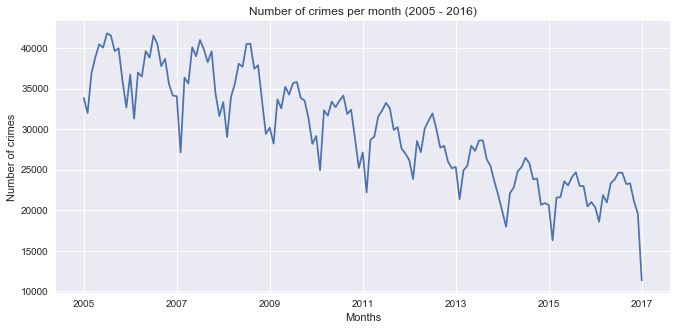

In [12]:
plt.figure(figsize=(11,5))
crimes.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2005 - 2016)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

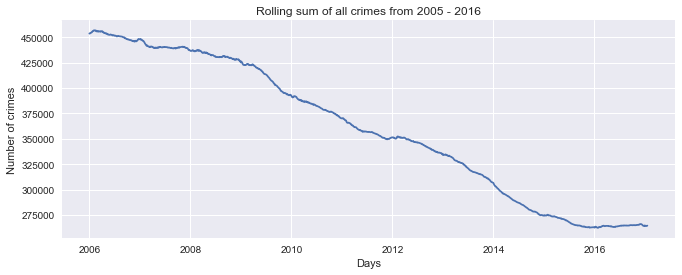

In [13]:
plt.figure(figsize=(11,4))
crimes.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2005 - 2016')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

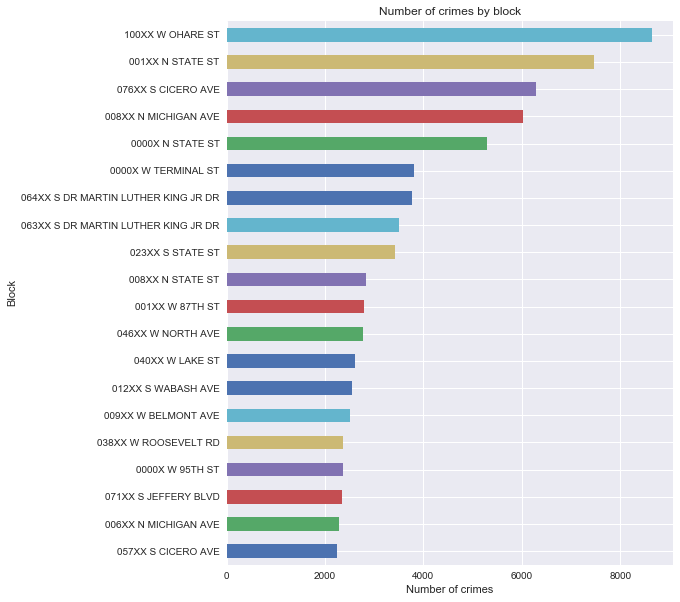

In [14]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Block']]).size().sort_values(ascending=True).head(20).plot(kind='barh')
plt.title('Number of crimes by block')
plt.ylabel('Block')
plt.xlabel('Number of crimes')
plt.show()

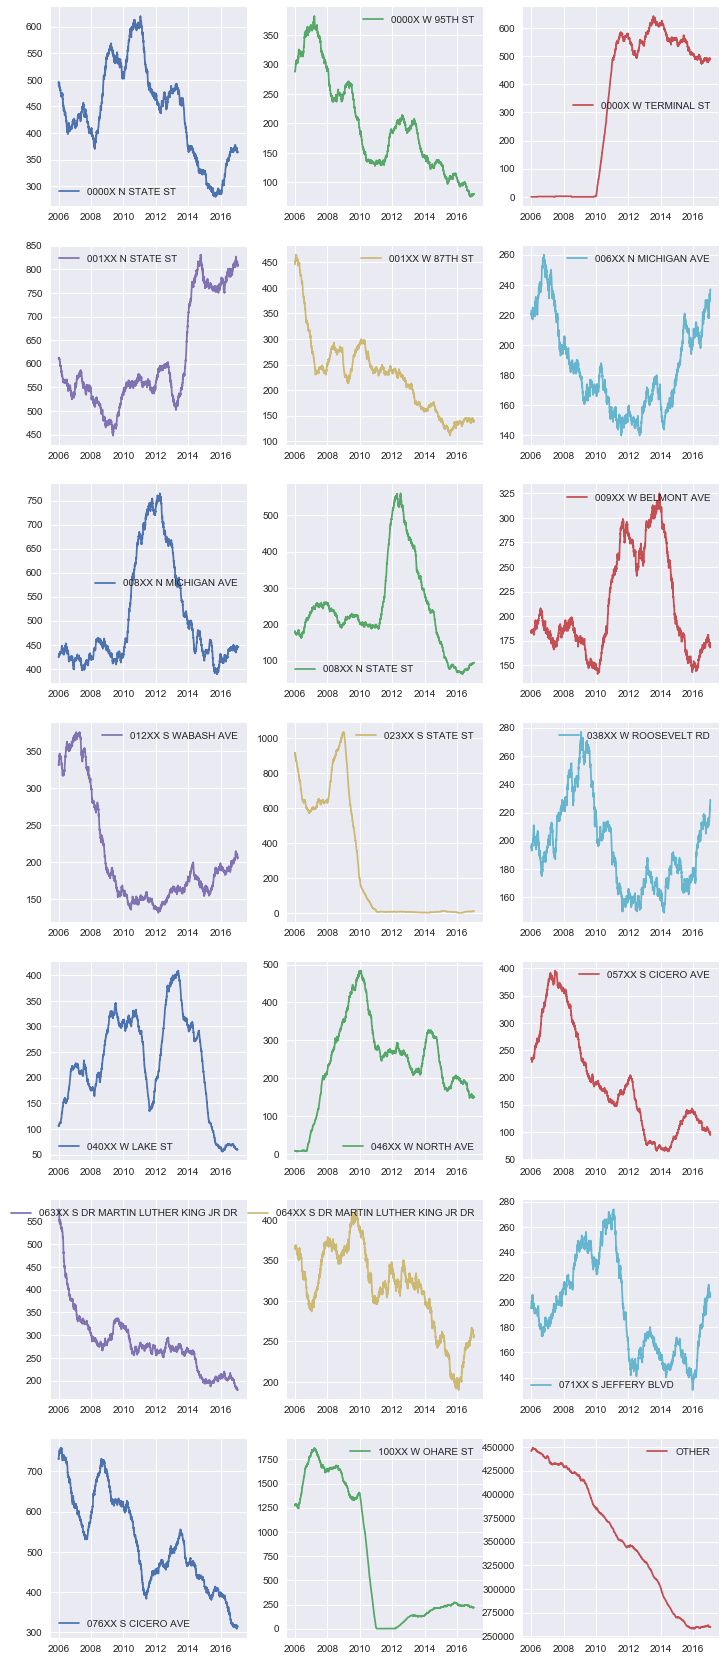

In [15]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Block', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

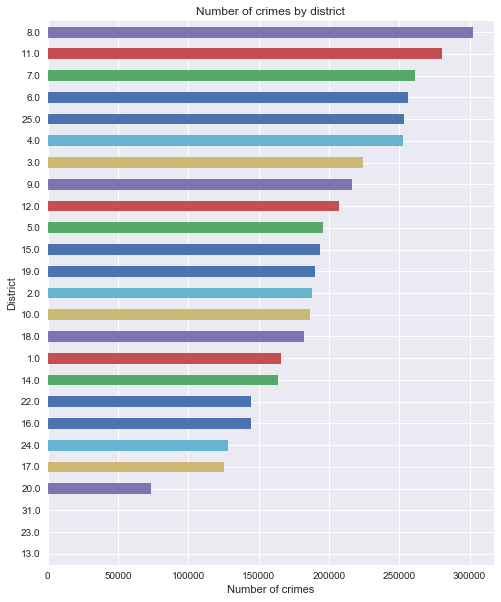

In [16]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['District']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by district')
plt.ylabel('District')
plt.xlabel('Number of crimes')
plt.show()

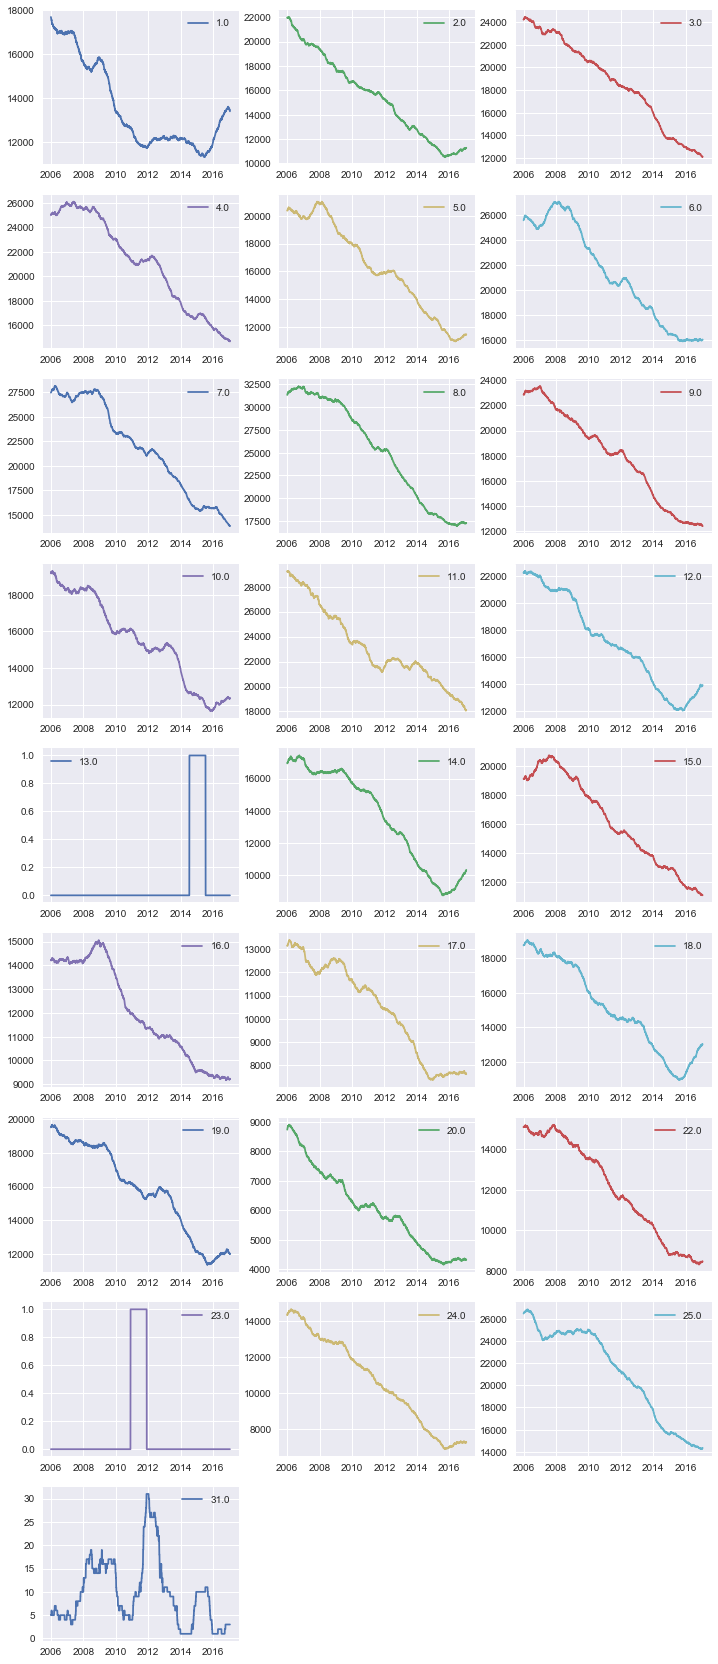

In [17]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='District', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

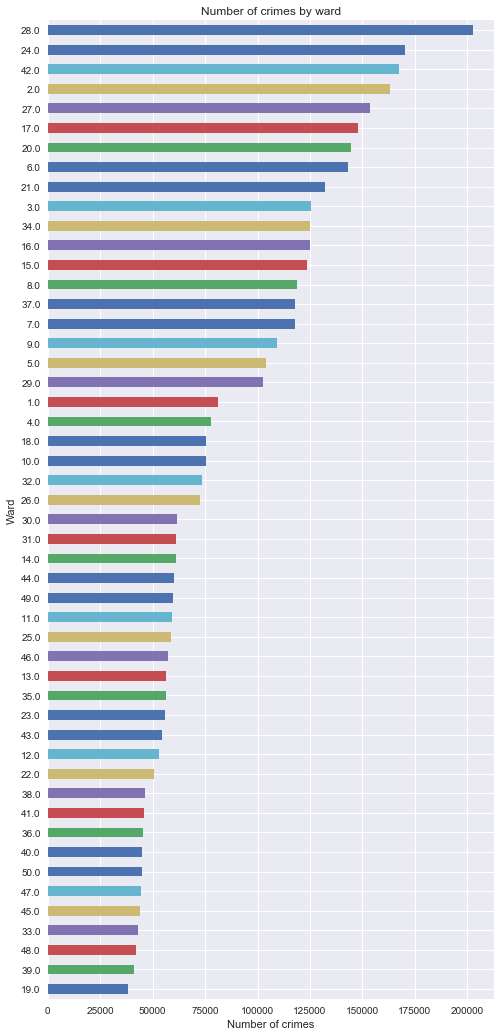

In [18]:
plt.figure(figsize=(8,18))
crimes.groupby([crimes['Ward']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by ward')
plt.ylabel('Ward')
plt.xlabel('Number of crimes')
plt.show()

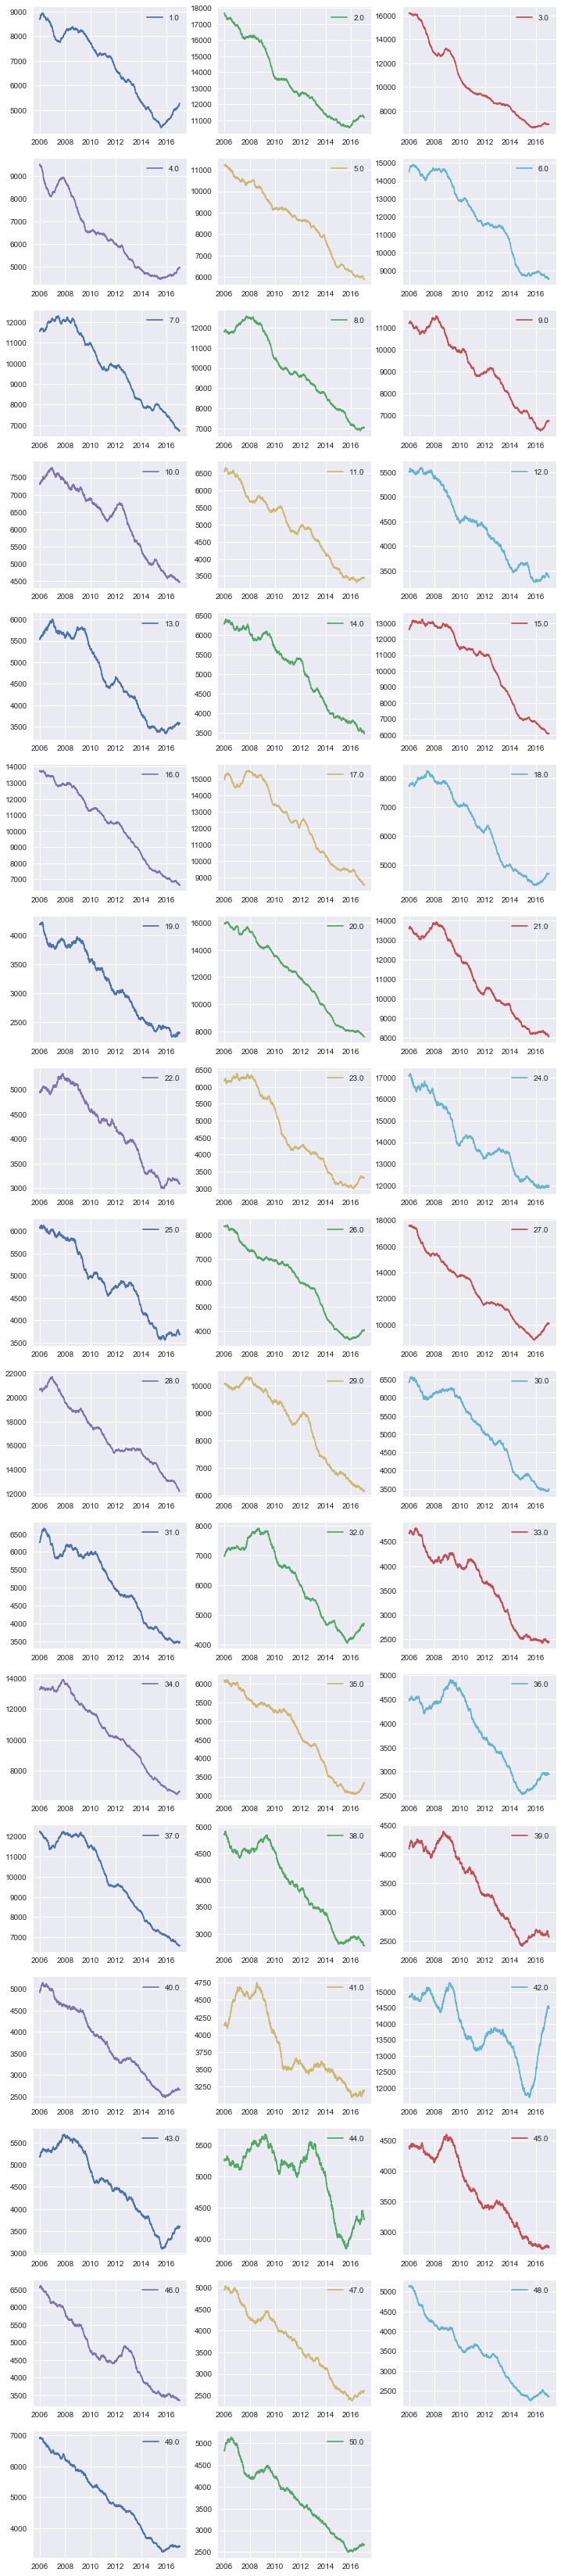

In [19]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Ward', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 60), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

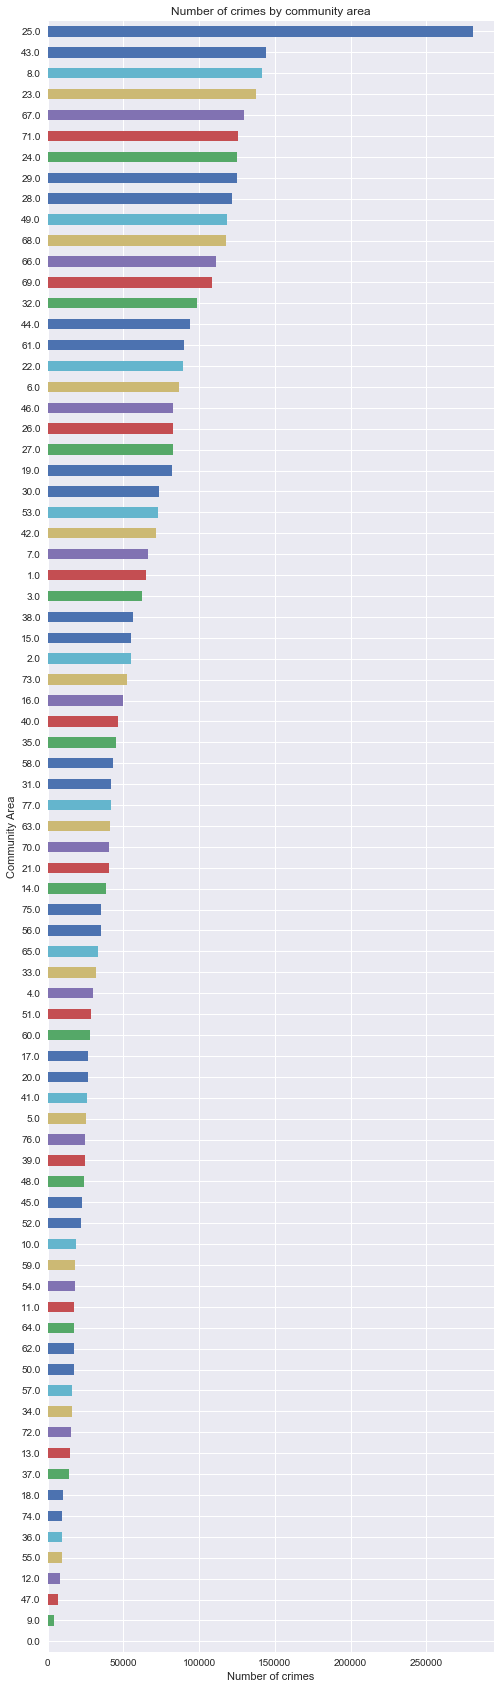

In [20]:
plt.figure(figsize=(8,30))
crimes.groupby([crimes['Community Area']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by community area')
plt.ylabel('Community Area')
plt.xlabel('Number of crimes')
plt.show()

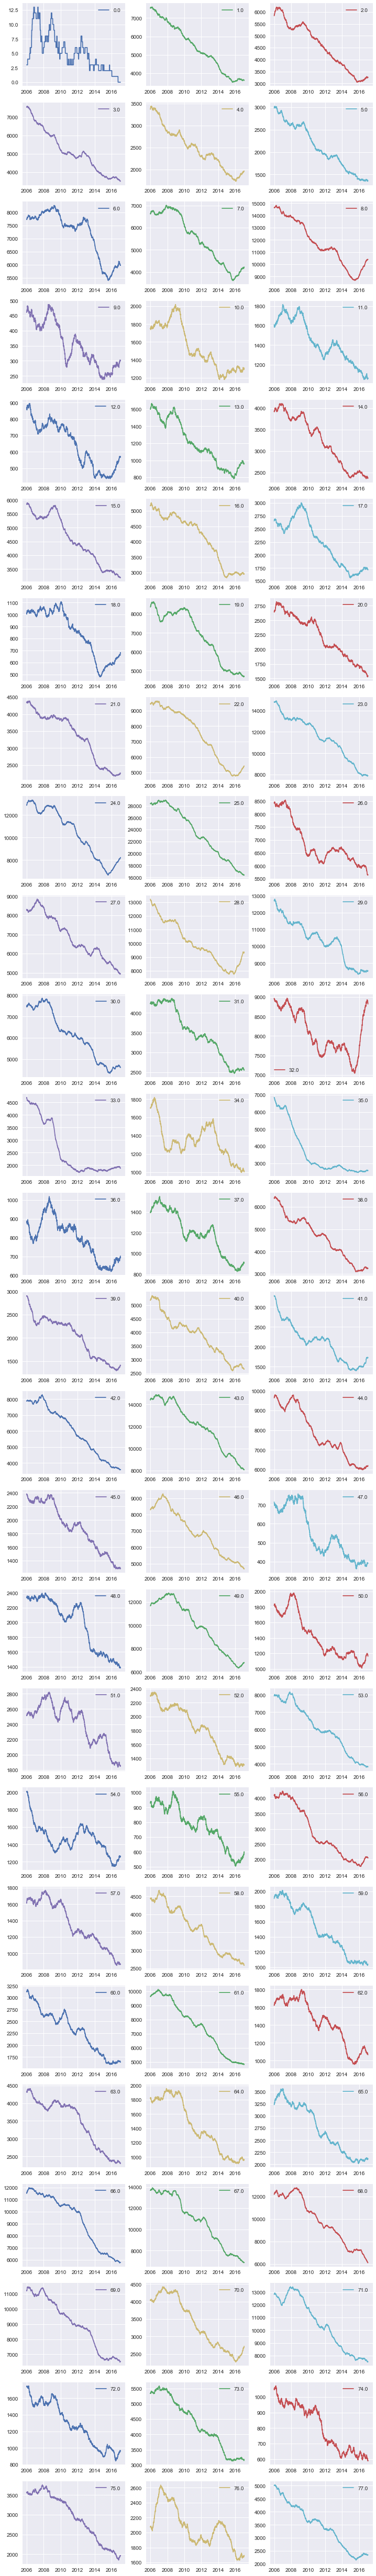

In [21]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Community Area', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 90), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

In [38]:
plt.figure(figsize=(8,70))
crimes.groupby([crimes['Beat']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Beat')
plt.ylabel('Beat')
plt.xlabel('Number of crimes')
plt.show()

ValueError: Length of grouper (1456714) and axis (4336556) must be same length

<Figure size 576x5040 with 0 Axes>

In [24]:
crimes1 = crimes[crimes['Year'] >= 2012]
grouped = crimes1.groupby([crimes1['Beat']])

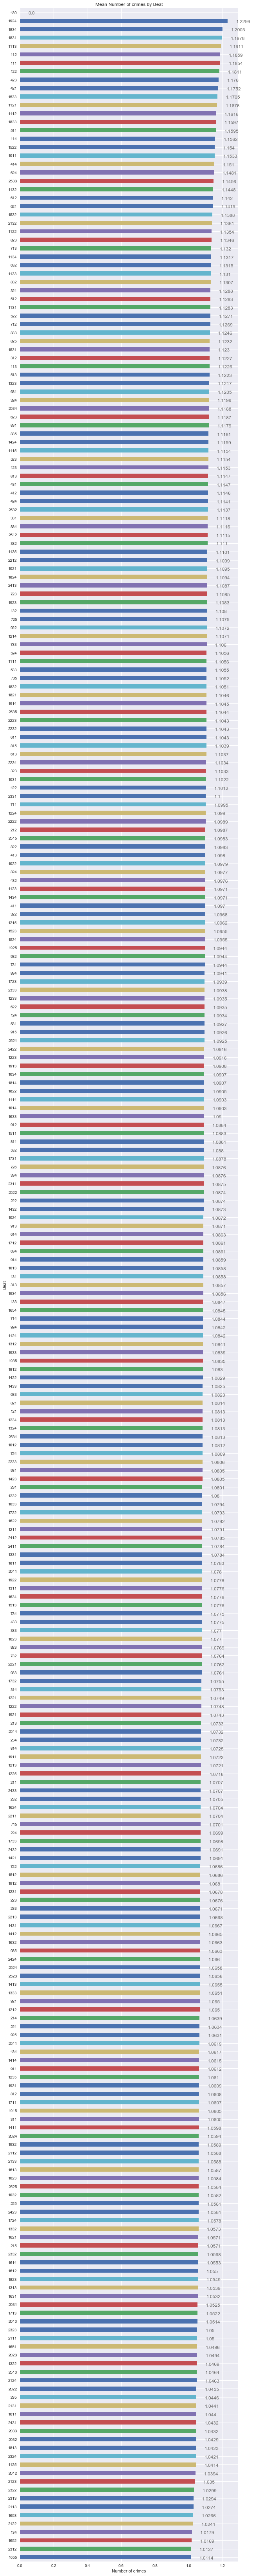

In [25]:
plt.figure(figsize=(10,120))
mean_crimes_per_hour = grouped.apply(lambda x: x.groupby([x['Y/M/D/H']]).size().mean()).sort_values(ascending=True)
ax = mean_crimes_per_hour.plot(kind='barh')
for i in ax.patches:
    ax.text(i.get_width()+.05, i.get_y()+0.01, str(round(i.get_width(),4)), fontsize = 12, color = 'dimgrey')
plt.title('Mean Number of crimes by Beat')
plt.ylabel('Beat')
plt.xlabel('Number of crimes')
plt.show()

In [26]:
p3 = len(mean_crimes_per_hour[mean_crimes_per_hour >= 1.20])
tmp = mean_crimes_per_hour[mean_crimes_per_hour >= 1.1] 
p2 = len(tmp[tmp < 1.2])
p1 = len(mean_crimes_per_hour[mean_crimes_per_hour < 1.1])
print("how many beats have mean number of crimes in [1.2, inf)", p3)
print("how many beats have mean number of crimes in [1.1, 1.2):", p2)
print("how many beats have mean number of crimes in [0, 1.1):", p1)


how many beats have mean number of crimes in [1.2, inf) 2
how many beats have mean number of crimes in [1.1, 1.2): 91
how many beats have mean number of crimes in [0, 1.1): 209


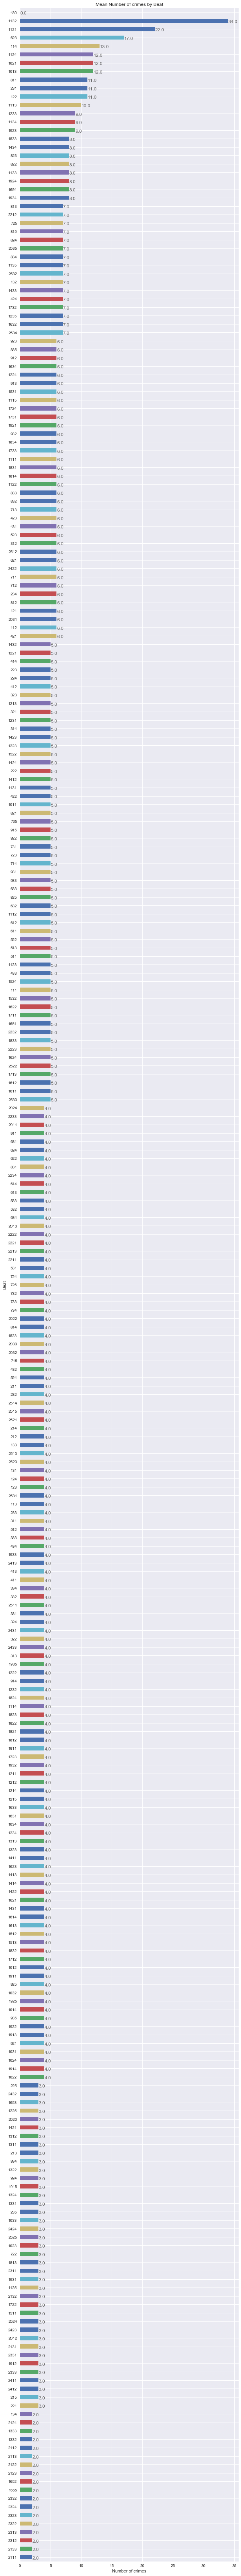

In [27]:
plt.figure(figsize=(10,120))
max_crimes_per_hour = grouped.apply(lambda x: x.groupby([x['Y/M/D/H']]).size().max()).sort_values(ascending=True)
ax = max_crimes_per_hour.plot(kind='barh')
for i in ax.patches:
    ax.text(i.get_width()+.05, i.get_y()+0.01, str(round(i.get_width(),4)), fontsize = 12, color = 'dimgrey')
plt.title('Mean Number of crimes by Beat')
plt.ylabel('Beat')
plt.xlabel('Number of crimes')
plt.show()

In [37]:
max_crimes_per_hour.groupby(max_crimes_per_hour).size()

2.0      18
3.0      39
4.0     116
5.0      55
6.0      36
7.0      16
8.0       8
9.0       3
10.0      1
11.0      3
12.0      3
13.0      1
17.0      1
22.0      1
34.0      1
dtype: int64

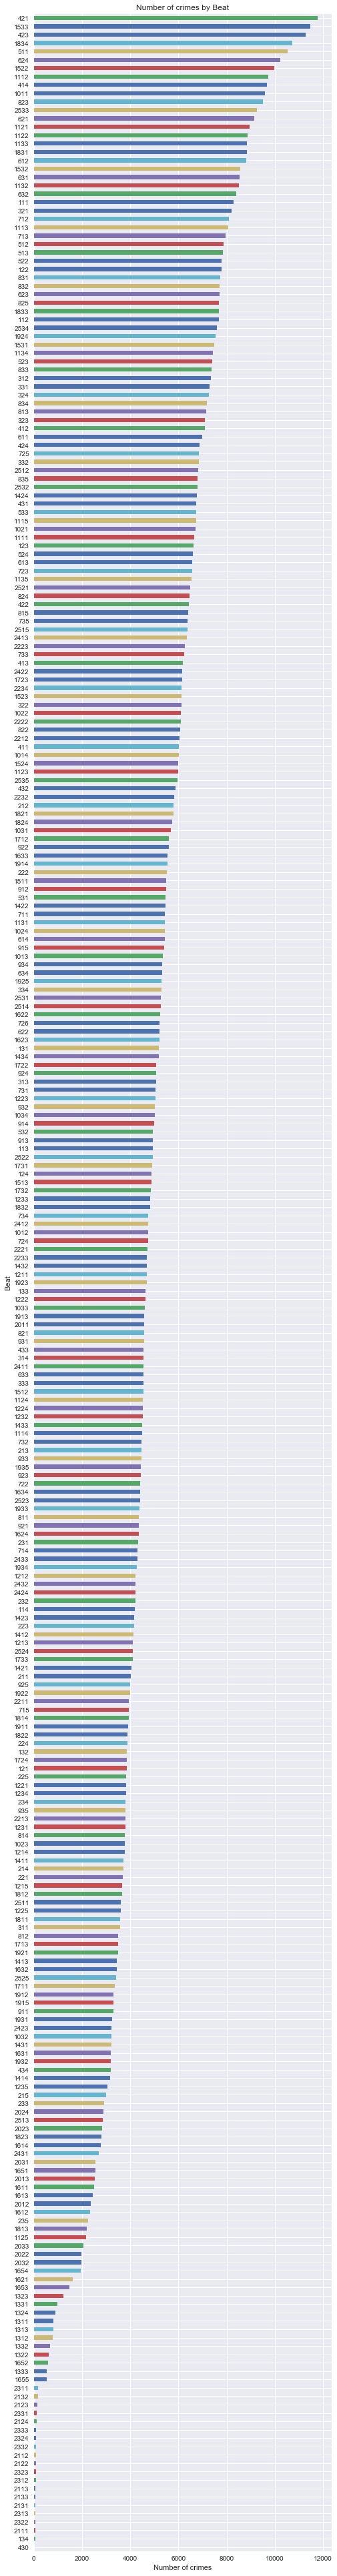

In [39]:
plt.figure(figsize=(8,70))
crimes1.groupby([crimes1['Beat']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Beat')
plt.ylabel('Beat')
plt.xlabel('Number of crimes')
plt.show()